In [1]:
import numpy as np

#data
D = np.asarray([[1,0],[2,0],[3,0],[5,6],[6,6],[7,6],[8,12],[9,12],[10,12],[11,18],[12,18],[13,18],[20,-5],[25,-5]])
#D = np.asarray([[1,0],[2,0],[3,0],[5,6],[6,6],[7,6]]) #,[20,-5]

In [2]:
from scipy import stats
from sklearn.cluster import MeanShift
import collections
import operator

'''
MeanShift based approach:
compute for all pairs of features (n^2-n)/2 in total amount, the highest-frequent mode, using MeanShift, 
at a specific bandwidth.


'''

def comode(data,bw):
    #prepare data first
    
    '''
    get every single dimension
    '''
    singledimlis = list(zip(*data))
    
    
    '''
    get all pairwise dimensions
    '''
    paireddimlis = []
    i = 0
    j = 0
    for i in range(len(singledimlis)):
        for j in range(len(singledimlis)):
            if i != j:
                pairdim = (list(zip(singledimlis[i],singledimlis[j])),(i,j))
                paireddimlis.append(pairdim)
            j = j+1
        i = i+1
        
    
    #compute meanshift now
    
    topmodelis = []
    
    for e in paireddimlis:
        d = e[0]
        clustering = MeanShift(bandwidth=bw).fit(d)
        modes = clustering.cluster_centers_
        labels = clustering.labels_
    
        #count for the number of objects per mode and their corresponding labels
        counter = collections.Counter(labels)
        #sorts in ascending order of frequency per mode, where (key,value) = (label,frequency)
        sortedmodes = sorted(counter.items(), key=operator.itemgetter(1))
        #obtain mode with highest id and highest frequency 
        topmode = modes[(sortedmodes[-1])[0]]
        topmodelis.append((topmode,e[1]))
    
    
    i = 0
    for f in singledimlis:
        d = np.asarray(f).reshape(-1, 1)
        clustering = MeanShift(bandwidth=bw).fit(d)
        modes = clustering.cluster_centers_
        labels = clustering.labels_
    
        #count for the number of objects per mode and their corresponding labels
        counter = collections.Counter(labels)
        #sorts in ascending order of frequency per mode, where (key,value) = (label,frequency)
        sortedmodes = sorted(counter.items(), key=operator.itemgetter(1))
        #obtain mode with highest id and highest frequency 
        topmode = modes[(sortedmodes[-1])[0]]
        bimode = np.append(topmode,topmode)
        topmodelis.append((bimode,(i,i)))
        i = i+1
    
    #for g in topmodelis:
    #    print(g)
        
    # now remove from each single dimension their respective top-mode value and multiply both with each other
    # take the array of values of dimension Xi and substract the corresponding mode from the mode vector; 
    # multiply it with (Xj - corresponding mode from mode vector)
    
    comodemx = np.zeros(shape=(len(data[0]),len(data[0])))
    
    for e in paireddimlis:
        for f in topmodelis:
            if e[1] == f[1]:
                X,Y = zip(*e[0])
                Xmode, Ymode = f[0]
                comodeprod = (np.asarray(X)-Xmode) * (np.asarray(Y)-Ymode)
                
                d = np.asarray(comodeprod).reshape(-1, 1)
                clustering = MeanShift(bandwidth=bw).fit(d)
                modes = clustering.cluster_centers_
                labels = clustering.labels_
    
                #count for the number of objects per mode and their corresponding labels
                counter = collections.Counter(labels)
                #sorts in ascending order of frequency per mode, where (key,value) = (label,frequency)
                sortedmodes = sorted(counter.items(), key=operator.itemgetter(1))
                #obtain mode with highest id and highest frequency 
                topmode = modes[(sortedmodes[-1])[0]]
                i,j = f[1]
                comodemx[i][j] = topmode[0]
    
    
    idx = 0
    for e in singledimlis:
        for f in topmodelis:
            if (idx,idx) == f[1]:
                X = e
                Xmode, Xmode = f[0]
                comodeprod = (np.asarray(X)-Xmode) * (np.asarray(X)-Xmode)
                
                d = np.asarray(comodeprod).reshape(-1, 1)
                clustering = MeanShift(bandwidth=bw).fit(d)
                modes = clustering.cluster_centers_
                labels = clustering.labels_
    
                #count for the number of objects per mode and their corresponding labels
                counter = collections.Counter(labels)
                #sorts in ascending order of frequency per mode, where (key,value) = (label,frequency)
                sortedmodes = sorted(counter.items(), key=operator.itemgetter(1))
                #obtain mode with highest id and highest frequency 
                topmode = modes[(sortedmodes[-1])[0]]
                i,j = f[1]
                comodemx[i][j] = topmode[0]
                
        idx = idx+1
    
    return comodemx
                


comode(D,6.5)

array([[  2.97916667,   4.5       ],
       [  4.5       , 289.        ]])

In [3]:
'''
transforming data:
Y = D * U 
where D is the data matrix, 
and U is the eigenvector matrix with the top k-PC
Y is the lower-dimensional projection
'''
def projectbyeigvec(data, eigvecmx, numpc):
    Y = np.dot(data,(eigvecmx[:numpc+1]).T)
    return Y



In [4]:
'''
reconstruction Z
= Y * U.T
'''
def reconstruct(dataproj, eigvecmx, numpc):
    Z = np.dot(dataproj,(eigvecmx[:numpc+1]))
    return Z
    


In [5]:
'''
Com Setting
'''

#CM = comedian(D)
CM = comode(D,2.0)


#compute eigenvalues and eigenvectors
w, v = np.linalg.eig(CM)

print(w)

Yp = projectbyeigvec(D,v,1)
Zmed = reconstruct(Yp, v, 1)


'''
Cov Setting
'''

mu = np.asarray([np.sum(D[:, :-1])/len(D[:, :-1]), 
                 np.sum(D[:, -1])/len(D[:, -1])])

#centered data
Xmu = D-mu

#alternatively:
Ca = np.cov(Xmu.T)

#compute eigenvalues and eigenvectors
w1, v1 = np.linalg.eig(Ca)
print(w1)

Ypca = projectbyeigvec(D,v1,1)
Zmean = reconstruct(Ypca, v1, 1)

[0.66666667 0.        ]
[43.69016735 68.57356891]


In [6]:
lossmean = ((D - Zmean) ** 2).mean()
print('Reconstruction Loss using Cov: ',lossmean)
lossmed = ((D - Zmed) ** 2).mean()
print('Reconstruction Loss using Com: ',lossmed)

Reconstruction Loss using Cov:  7.171943006618708e-30
Reconstruction Loss using Com:  0.0


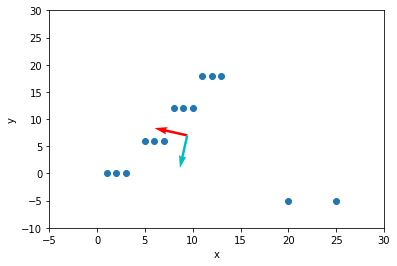

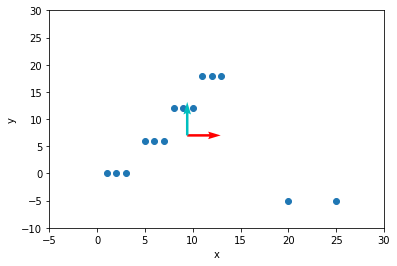

In [8]:
'''
Plotting PC on 2D data sets
'''
import matplotlib.pyplot as plt

def plotdatanpc(data, projecteddata, eigenvectors):
    mum = np.asarray([np.sum(D[:, :-1])/len(D[:, :-1]), 
                 np.sum(D[:, -1])/len(D[:, -1])])
    sigma = projecteddata.std(axis=0).mean()
    
    fig, ax = plt.subplots()
    x,y = zip(*data)
    ax.scatter(x, y)

    sigma = projecteddata.std(axis=0).mean()
    origin = data.mean(axis=0)

    plt.quiver(*origin, (eigenvectors[:,0]), (eigenvectors[:,1]), color=['r','c'], scale=10)
    #ax.set_aspect('equal')
    ax.set_ylim([-10,30])
    ax.set_xlim([-5,30])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()
    
plotdatanpc(D,Ypca,v1)
plotdatanpc(D,Yp,v)

In [9]:
'''
now some experiment on real-world data
from sklearn:
- iris
- wine
- digits
'''

from sklearn.datasets import load_iris, load_breast_cancer, load_digits
from sklearn.decomposition import PCA


def covPCA(data,numpc):
    
    '''
    mu = np.mean(data, axis=0)

    #centered data
    Xmu = data-mu

    #alternatively:
    Ca = np.cov(Xmu.T)

    #compute eigenvalues and eigenvectors
    w2, v2 = np.linalg.eig(Ca)
    
    idx = w2.argsort()[::-1]  
    w2 = w2[idx]
    v2 = v2[:,idx]
    print('v2: ',v2)
    '''
    
    
    pca = PCA(n_components=4)
    pca.fit(data)
    v1 = pca.components_
    print('v1: ',v1)

    Ypca = projectbyeigvec(data,v1, numpc)
    Zmean = reconstruct(Ypca, v1, numpc)
    
    return Zmean


def comPCA(data,bw,numpc):
    CM = comode(data,bw)

    #compute eigenvalues and eigenvectors
    w, v = np.linalg.eig(CM)
    
    idx = w.argsort()[::-1]  
    w = w[idx]
    v = v[:,idx]

    Yp = projectbyeigvec(data,v, numpc)
    Zmed = reconstruct(Yp, v, numpc)
    
    return Zmed
    

    
def compareLosses(Data,Zcov,Zcom):
    lossmean = ((Data - Zcov) ** 2).mean()
    #print('Reconstruction Loss using Cov: ',lossmean)
    lossmed = ((Data - Zcom) ** 2).mean()
    #print('Reconstruction Loss using Com: ',lossmed)
    return(lossmean,lossmed)
    

    
Diris = load_iris().data
#print(Diris)

'''
Ziriscov = covPCA(d1,2)
Ziriscom = comPCA(d1,2)
compareLosses(d1,Ziriscov,Ziriscom)
'''

print('--------------------------------')

'''
Ddigits = load_digits().data

Zdigcov = covPCA(Ddigits,63)
Zdigcom = comPCA(Ddigits,63)
compareLosses(Ddigits,Zdigcov,Zdigcom)
'''


--------------------------------


'\nDdigits = load_digits().data\n\nZdigcov = covPCA(Ddigits,63)\nZdigcom = comPCA(Ddigits,63)\ncompareLosses(Ddigits,Zdigcov,Zdigcom)\n'

In [10]:
'''
track the loss for PCA with cov and PCA with com
using different number of PC
'''


irislosslis = []
irislosslis1 = []
irislosslis2 = []

#0.1 a good bw
#4.0 a bad bw
#8.0 converges to covariance values --> since all objects collapse to a single mode
#future work: dimension specific bw., using second, third etc. largest mode in multimodal setting; 
#how to find and choose a good bw?

for i in range(0,4):
    Ziriscov = covPCA(Diris,i)
    Ziriscom = comPCA(Diris,0.1,i)
    Ziriscom1 = comPCA(Diris,4.0,i)
    Ziriscom2 = comPCA(Diris,5.5,i)
    compres = compareLosses(Diris,Ziriscov,Ziriscom)
    compres1 = compareLosses(Diris,Ziriscov,Ziriscom1)
    compres2 = compareLosses(Diris,Ziriscov,Ziriscom2)
    irislosslis.append(compres)
    irislosslis1.append(compres1)
    irislosslis2.append(compres2)

print('------')



'''
penlosslis = []

for j in range(0,64):
    Zdigcov = covPCA(Ddigits,j)
    Zdigcom = comPCA(Ddigits,j)
    compres = compareLosses(Ddigits,Zdigcov,Zdigcom)
    penlosslis.append(compres)
'''

v1:  [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]
 [-0.58202985  0.59791083  0.07623608  0.54583143]
 [-0.31548719  0.3197231   0.47983899 -0.75365743]]
v1:  [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]
 [-0.58202985  0.59791083  0.07623608  0.54583143]
 [-0.31548719  0.3197231   0.47983899 -0.75365743]]
v1:  [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]
 [-0.58202985  0.59791083  0.07623608  0.54583143]
 [-0.31548719  0.3197231   0.47983899 -0.75365743]]
v1:  [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]
 [-0.58202985  0.59791083  0.07623608  0.54583143]
 [-0.31548719  0.3197231   0.47983899 -0.75365743]]
------


'\npenlosslis = []\n\nfor j in range(0,64):\n    Zdigcov = covPCA(Ddigits,j)\n    Zdigcom = comPCA(Ddigits,j)\n    compres = compareLosses(Ddigits,Zdigcov,Zdigcom)\n    penlosslis.append(compres)\n'

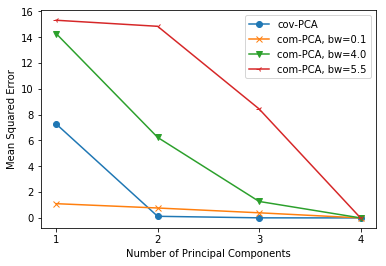

In [11]:
import matplotlib.pyplot as plt

pcirisrange = [i for i in range(1,5)]
coviloss, comiloss = zip(*irislosslis)
coviloss1, comiloss1 = zip(*irislosslis1)
coviloss2, comiloss2 = zip(*irislosslis2)
plt.plot(pcirisrange,coviloss,'-o', label='cov-PCA')
plt.plot(pcirisrange,comiloss,'-x', label='com-PCA, bw=0.1')
plt.plot(pcirisrange,comiloss1,'-v', label='com-PCA, bw=4.0')
plt.plot(pcirisrange,comiloss2,'-3', label='com-PCA, bw=5.5')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Squared Error')
plt.xticks(pcirisrange)


plt.legend()
plt.show()

In [ ]:

pcrange = [i for i in range(0,64)]
covloss, comloss = zip(*penlosslis)
plt.plot(pcrange,covloss,'-o')
plt.plot(pcrange,comloss,'-x')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Squared Error')
plt.show()